In [1]:
import random
import tensorflow as tf
from tensorflow.keras import layers, utils, models
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "./sig_images"

In [3]:
def load_data(DATA_DIR=DATA_DIR, test_size=0.3, load_grayscale=True):
    """
        Loads the data into a dataframe.
        
        Arguments:
            DATA_DIR: str
            test_size: float
        Returns:
            (x_train, y_train,x_test, y_test, x_val, y_val, df)
    """
    all_imgs = []
    imgs_forged = []
    imgs_real = []
    features_dict = {}
    labels = [] # forged: 0 and real:
    mode = "rgb"
    if load_grayscale:
        mode = "grayscale"
    
    for folder in os.listdir(DATA_DIR):
        # forged images
        for sub in os.listdir(DATA_DIR+"/forge"):
            if ".Jpeg" not in sub:
                continue
            f = DATA_DIR+"/forge/" + sub
            img = utils.load_img(f, color_mode=mode, target_size=(150,150))
            all_imgs.append(utils.img_to_array(img))
            features_dict[sub] = (img, 0)
            imgs_forged.append(img)
            labels.append(0) # forged

        # real images
        for sub in os.listdir(DATA_DIR+"/real"):
            if ".Jpeg" not in sub:
                continue
            f = DATA_DIR+"/real/" + sub
            img = utils.load_img(f, color_mode=mode, target_size=(150,150))
            all_imgs.append(utils.img_to_array(img))
            features_dict[sub] = (img, 1)
            imgs_real.append(img)
            labels.append(1) # real
            
    features = np.array(all_imgs)
    labels = np.array(labels)
    
    X_train, X_remain, y_train, y_remain = train_test_split(features, labels, test_size=test_size, random_state=228)
    X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=228)

    
    print ("Generated data.")

    return X_train, X_test, X_valid, y_train, y_test, y_valid, features, labels, features_dict



In [4]:
X_train, X_test, X_valid, y_train, y_test, y_valid, features, labels, features_dict = load_data(load_grayscale=False)

Generated data.


In [5]:
#divided by 255: Because the values in the dataset range from 0 to 255.
X_train = X_train/255.0
X_test = X_test/255.0
X_valid = X_valid/255.0

In [6]:
def label_to_text(label=0):
    return "Forged" if label == 0 else "Real"

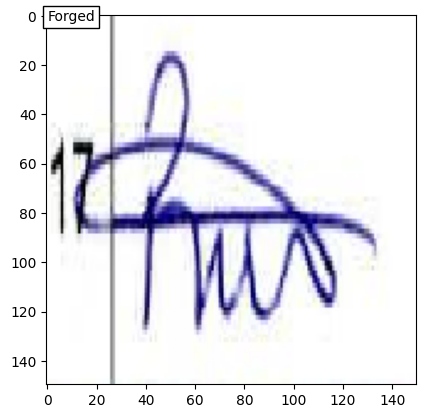

In [7]:
idx = random.randint(0, len(X_train))

plt.imshow(X_train[idx, :])
plt.text(0, 2, label_to_text(labels[idx]), bbox={'facecolor': 'white', 'pad': 3})
plt.show()

In [8]:
def mse(y_true, y_pred):
    return np.square(np.subtract(y_true,y_pred)).mean()

A = features_dict["22T10.Jpeg"]
B = features_dict["22F10.Jpeg"]

A_array = utils.img_to_array(A[0])
B_array = utils.img_to_array(B[0])

print ("MSE Error: {}".format(mse(A_array, B_array)))

MSE Error: 3624.58447265625


## Use Sequential model:
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

### **Convolution Neutral Network** ref link:
* https://www.youtube.com/@CodingLane
* https://towardsdatascience.com/build-your-first-image-classifier-with-convolution-neural-network-cnn-b4e9034ec5cb

* Tune CNN: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

In [9]:
model = models.Sequential()
# how many layer should I use
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(pool_size=3))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-05-22 00:05:55.221049: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-22 00:05:55.221902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16928)             0         
                                                                 
 dense (Dense)               (None, 64)                1

In [11]:
history = model.fit(X_train, y_train, epochs= 10, batch_size=100, validation_data = (X_valid, y_valid))

Epoch 1/10


2023-05-22 00:05:55.861114: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-22 00:05:56.107910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.5063

2023-05-22 00:05:58.272177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 3s 43ms/step - loss: 0.7424 - accuracy: 0.5063 - val_loss: 0.6871 - val_accuracy: 0.5682
Epoch 2/10
46/46 [==============================] - 1s 31ms/step - loss: 0.6699 - accuracy: 0.6004 - val_loss: 0.6440 - val_accuracy: 0.6384
Epoch 3/10
46/46 [==============================] - 1s 30ms/step - loss: 0.5976 - accuracy: 0.6794 - val_loss: 0.5655 - val_accuracy: 0.7169
Epoch 4/10
46/46 [==============================] - 1s 33ms/step - loss: 0.5304 - accuracy: 0.7368 - val_loss: 0.4982 - val_accuracy: 0.7562
Epoch 5/10
46/46 [==============================] - 1s 29ms/step - loss: 0.4609 - accuracy: 0.7844 - val_loss: 0.4847 - val_accuracy: 0.7583
Epoch 6/10
46/46 [==============================] - 1s 29ms/step - loss: 0.4109 - accuracy: 0.8129 - val_loss: 0.5741 - val_accuracy: 0.6901
Epoch 7/10
46/46 [==============================] - 1s 30ms/step - loss: 0.3586 - accuracy: 0.8501 - val_loss: 0.3706 - val_accuracy: 0.8378
Epoch 8/10
46/46 [======

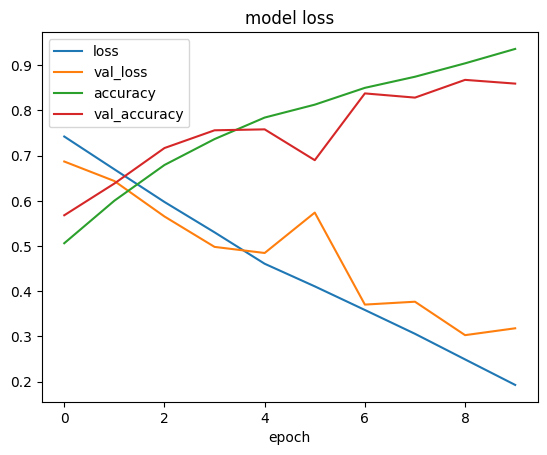

In [12]:
# val_loss: the value of cost function for your cross-validation data
# loss: the value of cost function for your training data.

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'], loc='upper left')
    plt.show()

plot_history(history)

In [13]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 9ms/step - loss: 0.3262 - accuracy: 0.8554


[0.32616427540779114, 0.8553719520568848]

## Make Prediction for all images

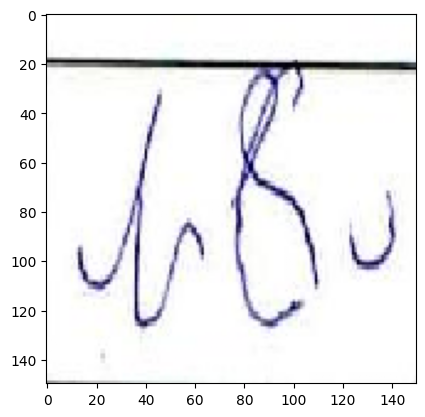

1/1 [==============================] - 0s 75ms/step
prediction: Forged, actual: is Forged


2023-05-22 00:06:11.634442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [14]:
idx2 = random.randint(0, len(features))
plt.imshow(features[idx2, :] / 255.)
plt.show()

y_pred = model.predict(features[idx2, :].reshape(1, 150, 150, 3))
y_pred = 1 if y_pred > 0.5 else 0

print("prediction: {}, actual: is {}".format(label_to_text(y_pred), label_to_text(labels[idx2])))